In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import subsystem2 # import relevant, abstracted code
import math
from pprint import pprint

import numpy as np
from statistics import mean
import random
random.seed(12345)
np.random.seed(12345)

plt.rcParams["font.family"] = "serif"
plt.rcParams["savefig.dpi"] = 150

def newfigure():
    fig = plt.figure()
    plt.tick_params(direction='in', grid_linestyle=":", top=True, right=True)
    plt.grid(which='major', axis='both', linestyle=":")
    return fig

# 1. Initial investigation

Firstly, using the output of the first subsystem, we can model the physical behaviour of the lift in order to determine travel times between floors.

Since the lift is being modelled with constant, or zero, acceleration/deceleration, we can fully derive these characteristics. The result of which has been coded into the `subsystem.py` python file.

The lift characteristics have been instantiated with fairly arbritrary parameters. This is in order to decouple the subsystem from subsystem 1. The main difference of altering these parameters is the required distance/time in order for a lift to reach maximum velocity.

The distance required to reach maximum velocity:     25.0
Number of floors required to reach maximum velocity: 6.25
The time taken to reach maximum velocity:            10.0

travel_time(n) calculates total time taken (seconds) to travel n integer floors this included closing of the doors and opening at the destination.

        

n =  1    Travel = 11.657 seconds
n =  2    Travel = 14.000 seconds
n =  3    Travel = 15.798 seconds
n =  4    Travel = 17.314 seconds
n =  5    Travel = 18.649 seconds


<IPython.core.display.Javascript object>


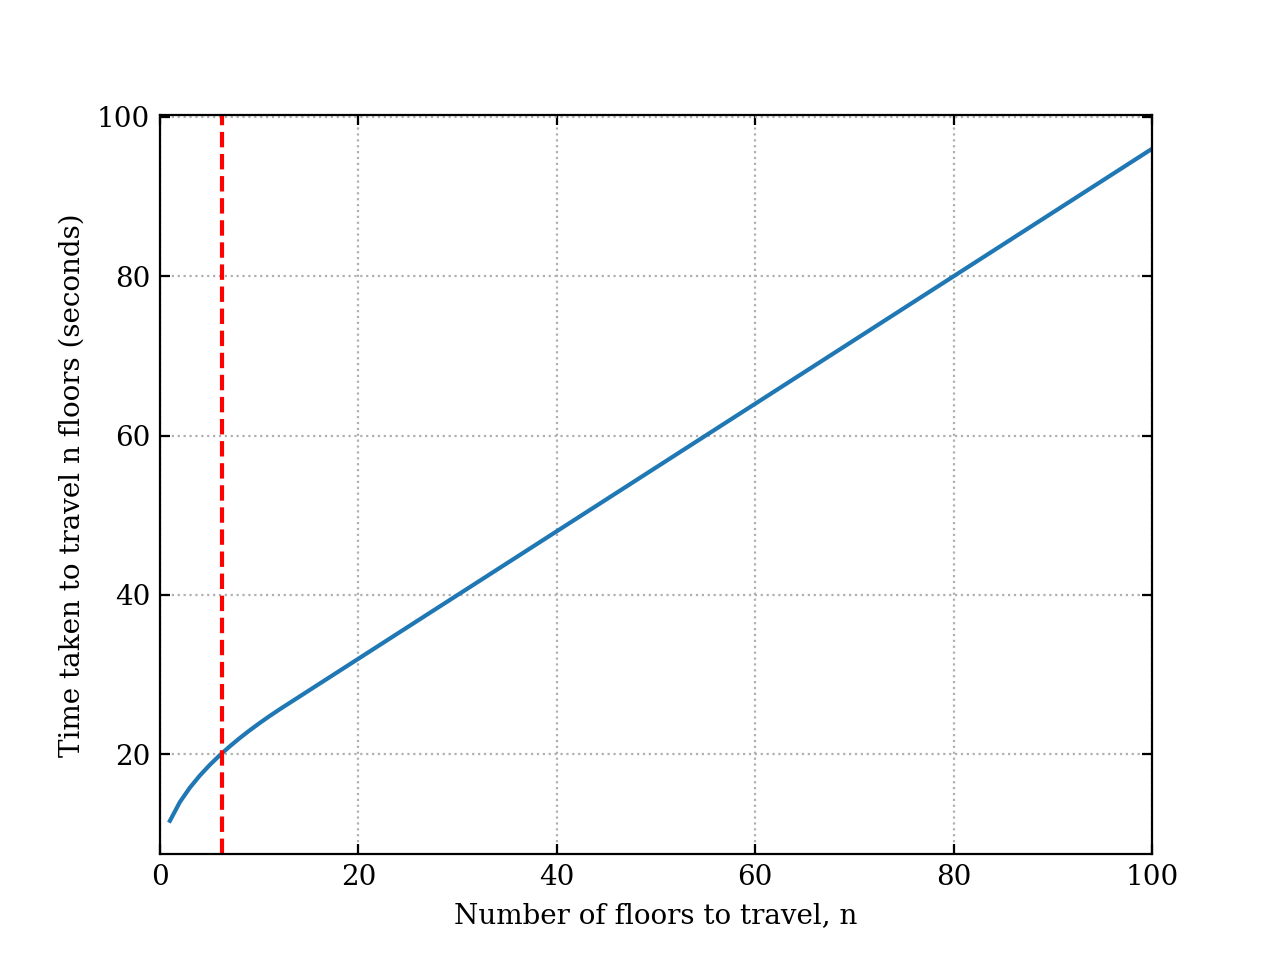

In [2]:
lift = subsystem2.Lift( vmax = 5.0, 
                        acc  = 0.5, 
                        door_time    = 3.0,
                        floor_height = 4.0)

print("The distance required to reach maximum velocity:     {:4}".format(lift.smv))
print("Number of floors required to reach maximum velocity: {:4}".format(lift.smv/lift.df))
print("The time taken to reach maximum velocity:            {:4}".format(lift.tmv))

print("\n"+lift.travel_time.__doc__+"\n")

nfloors = 100
ns = range(1, nfloors+1)
Ts = []
    
for n in ns:
    t = lift.travel_time(n)
    Ts.append(t)
    if n < 6:
        print("n = {0:2d}    Travel = {1:6.3f} seconds".format(n,t))


newfigure()
plt.plot(ns, Ts)
plt.axvline(x=lift.smv/lift.df, linestyle="--", color="red")
plt.ylabel("Time taken to travel n floors (seconds)")
plt.xlabel("Number of floors to travel, n")
plt.xlim(0, nfloors)
plt.show()
plt.savefig('output/floorsvtime.png')

The graph shows that beyond the threshold of reaching maximum velocity, the change in travel time simply scales linearly, as expected.

# Challenging Assumptions

A natural assumption 

Next, comparing the travel time of a lift going to floors spread out vs travel further and do consecutive floors:

<IPython.core.display.Javascript object>


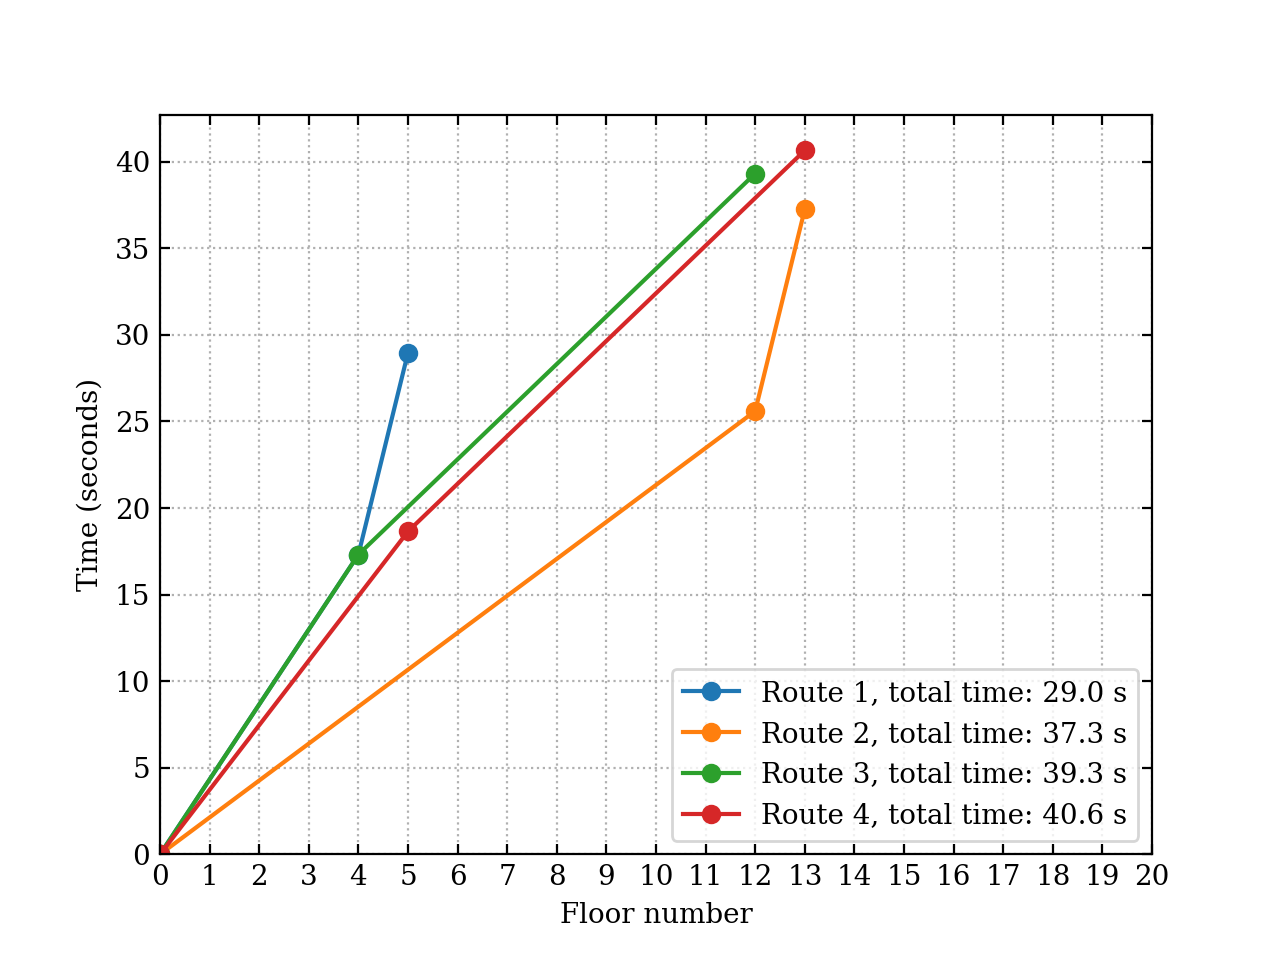

Route 1: 28.97 sec with average travel time 15.43 sec
Route 2: 37.25 sec with average travel time 20.95 sec
Route 3: 39.31 sec with average travel time 18.88 sec
Route 4: 40.65 sec with average travel time 19.77 sec
Average time of route 1 & 2: 27.283 sec
Average time of route 3 & 4: 28.981 sec


In [3]:
# routes = [[0,  5, 10, 15, 20],
#           [0, 17, 18, 19, 20],
#           [0,  1,  3, 19, 20]]

routes = [[0,  4,  5],
          [0, 12, 13],
          [0,  4, 12],
          [0,  5, 13]]

rct = [lift.comp_travel(r) for r in routes]
llabels = []

route_passenger_times = []

newfigure()

for i, r in enumerate(routes):
    
    rct = lift.comp_travel(r)
    route_passenger_times.append(rct[1:])
    print("Route {:d}: {:5.2f} sec with average travel time {:.2f} sec".format(i+1, rct[-1], np.mean(rct)))
    
    plt.plot(r, rct, '-o')
    llabels.append("Route {:}, total time: {:.1f} s".format(i+1, rct[-1]))

plt.ylabel("Time (seconds)")
plt.xlabel("Floor number")
plt.xticks(range(0, 21))
plt.xlim(0,20)
plt.ylim(0)
plt.legend(llabels)
plt.show()
plt.savefig('output/comp_travel.png')

print("Average time of route 1 & 2: {:.3f} sec".format(np.mean(route_passenger_times[0:2])))
print("Average time of route 3 & 4: {:.3f} sec".format(np.mean(route_passenger_times[2:])))

This graph showed us that bundling destination floors together can actually result in a lower average travel time per user. Additionally, for future use, *route 1* would result in an lift becoming significantly faster than any alternative.

# Testing a greed allocation algorithm

- Pass in a list of users, represented as their destination floor number.
- The arrive through a single allocation keypad.
- There will be 20 users, each going to a different random floor from a 30 storey building

- Now I'll try to pass in a list of users, represented as the floor number they want to go to. 
- They arrive in an order and enter their floor one by one so a list is suitable input.
- The first list of users will be a group of 20, each wanting to go to a different floor in a 30 story building.
- Each lift will take one user at a time.
- Greedy algorithm will assign to first available lift.


In [4]:
n_users = 20
n_floors = 30
n_lifts = 8

users = list(range(1,n_floors+1))

print("Created a list of {:} users".format(len(users)))
print("Removing {} users from the list".format(n_floors-n_users))

for i in range(n_floors-n_users):
    randuser = random.randint(0, len(users)-1)
    del users[randuser]

print("Shuffling order of the users".format(len(users)))
random.shuffle(users)
print(users)

# create the lift struct
lifts = []
for l in range(n_lifts):
  lifts.append([])

# assign each user to lifts
lift_id = 0
for user in users:
  lifts[lift_id].append(user)
  lift_id = (lift_id+1) % len(lifts)


total_time = 0
lift_times = []
lift_avgs = []
  
print("\nLifts went to the following floors:")
for i, users in enumerate(lifts):
    t = 0
    liftq = users.copy()
    while len(liftq) > 0:
        user = liftq.pop(0)
        waiters = len(liftq)    
        travel = lift.travel_time(user)
        t += travel + 2*waiters*lift.travel_time(user)
  
    lift_times.append(t)
    lift_avgs.append(t/len(users))
    print("  Lift {0:} traveled for {2:4.0f} seconds, with average user time of {3:3.0f} secs/user, and went to floors: {1:}".format(i, users, t, t/len(users)))

total_time = sum(lift_times)
print("\nTotal travel time {:.0f} sec with an average travel time of {:.0f} sec/user".format(total_time, mean(lift_avgs)))

Created a list of 30 users
Removing 10 users from the list
Shuffling order of the users
[3, 21, 19, 23, 2, 9, 10, 27, 24, 22, 16, 4, 17, 13, 6, 28, 5, 18, 7, 20]

Lifts went to the following floors:
  Lift 0 traveled for  203 seconds, with average user time of  68 secs/user, and went to floors: [3, 24, 5]
  Lift 1 traveled for  295 seconds, with average user time of  98 secs/user, and went to floors: [21, 22, 18]
  Lift 2 traveled for  263 seconds, with average user time of  88 secs/user, and went to floors: [19, 16, 7]
  Lift 3 traveled for  256 seconds, with average user time of  85 secs/user, and went to floors: [23, 4, 20]
  Lift 4 traveled for   72 seconds, with average user time of  36 secs/user, and went to floors: [2, 17]
  Lift 5 traveled for   95 seconds, with average user time of  48 secs/user, and went to floors: [9, 13]
  Lift 6 traveled for   92 seconds, with average user time of  46 secs/user, and went to floors: [10, 6]
  Lift 7 traveled for  151 seconds, with average u

# Modelling passenger arrival

As seen in literature review, many papers discuss modelling passenger arrival as compound poisson distribution. This however is unnecessarily complex for the purposes of this model. As such, the high fidelity modelling of passenger arrival will be done through a random poisson distribution, and the parameters for this will be controlled by a custom spline fitting on a macro scale.

In [5]:
# 9 am
nine = 9*60*60
tenmin = 10*60
print("9 am is t= {}".format(nine))
print("10 min period is t= {}".format(tenmin))
print(60*60*2)

9 am is t= 32400
10 min period is t= 600
7200


<IPython.core.display.Javascript object>


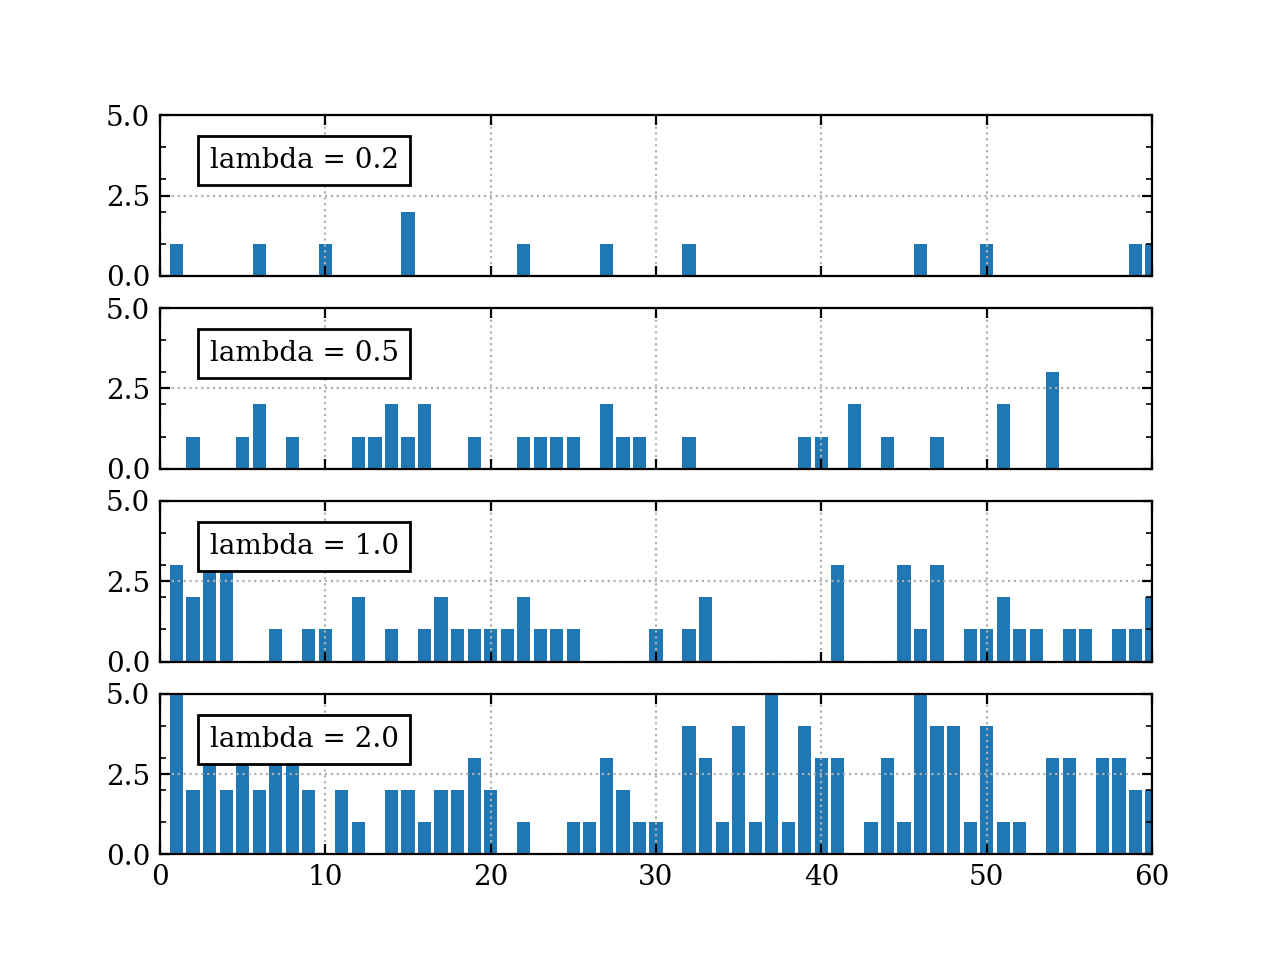

In [6]:
lams = [0.2, 0.5, 1.0, 2.0]
pds = [np.random.poisson(lam=l, size=60) for l in lams]
fig, axarr = plt.subplots(len(lams), sharex=True)
for i, l in enumerate(lams):
    axarr[i].bar(np.arange(1,len(pds[i])+1), pds[i])
    
    m = np.amax(pds)
    axarr[i].set_xlim(0,60)
    axarr[i].set_ylim(0,m)
    axarr[i].set_yticks(np.arange(0,m,1), minor=True)
    
    axarr[i].tick_params(which='both', direction='in', grid_linestyle=":", top=True, right=True)
    axarr[i].grid(which='major', axis='both', linestyle=":")
    axarr[i].text(3, np.amax(pds)-1, 'lambda = {}'.format(l), verticalalignment='top', bbox={'facecolor':'white'})

fig.savefig('output/poisson_comparison.png')

<IPython.core.display.Javascript object>


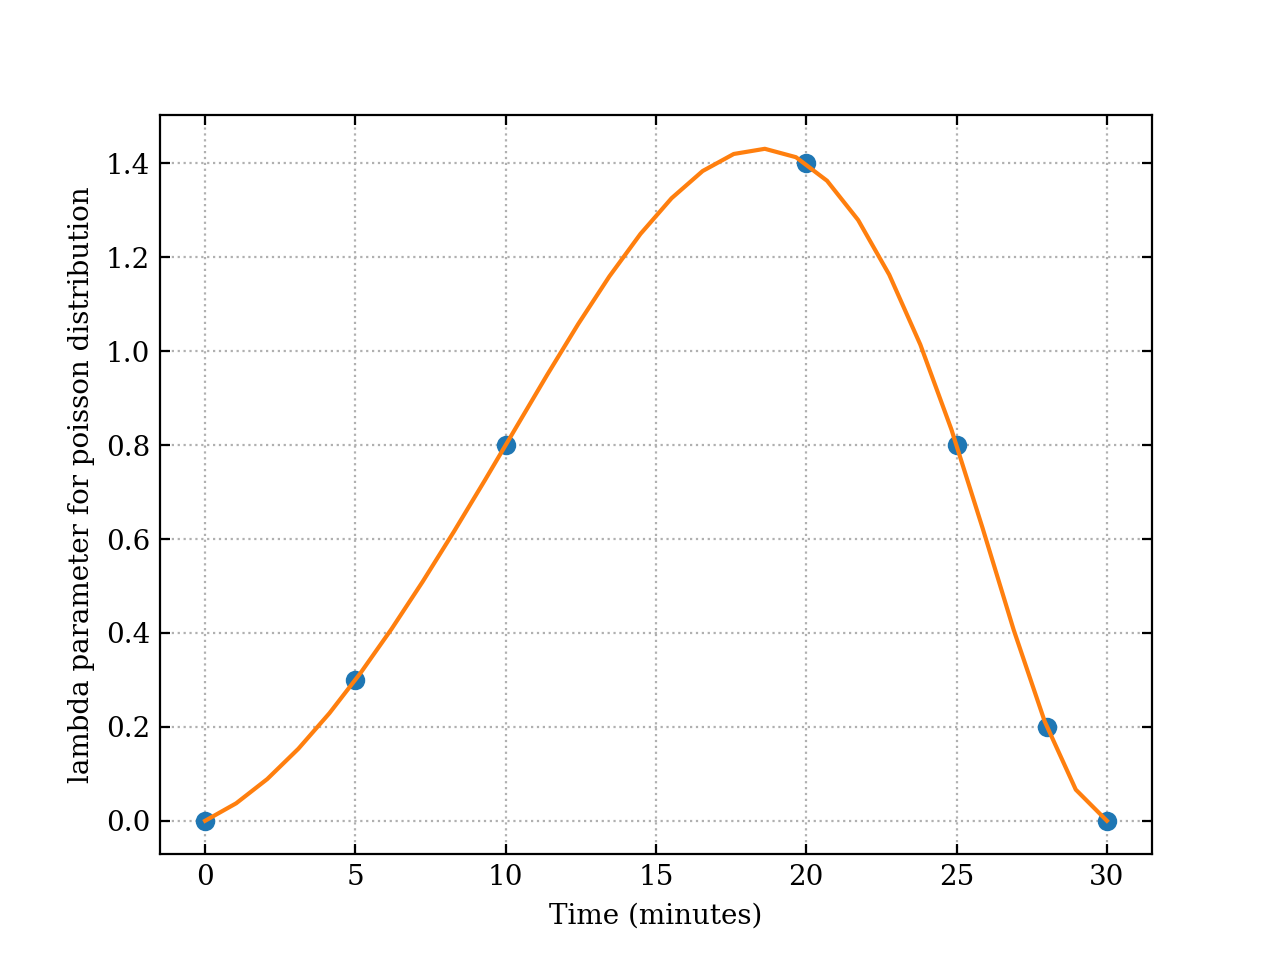

In [7]:
# from scipy.stats import norm
# x = np.linspace(0, 7200, 7200)
# newfigure()
# plt.plot(x, norm.pdf(x, 4000, 800))

from scipy.interpolate import interp1d

xf = [0,1,5,10,20,25,28,30]
yf = [0,0.2,0.1,0.4,1.2,0.4,0,0]

coords = [(0,0),
          (5,0.3),
          (10,0.8),
          (20,1.4),
          (25,0.8),
          (28,0.2),
          (30,0)]


xf, yf =  zip(*coords)

f = interp1d(xf, yf, kind='cubic')

xnew = np.linspace(0, 30, num=30)
ynew = f(xnew).clip(min=0)

newfigure()
plt.plot(xf, yf, 'o', xnew, ynew, '-')
plt.xlabel('Time (minutes)')
plt.ylabel('lambda parameter for poisson distribution')
# plt.legend(['data', 'linear', 'cubic'], loc='best')

xtn = range(0,31,5)
xtl = range(0,31,1*5)
plt.xticks(xtn,xtl)
plt.show()

plt.savefig('output/spline_control.png')

For every 60 second period, sample the control spline, use the value to set as lambda parameter of the poisson distribution. Generate 60 second period of traffic.

<IPython.core.display.Javascript object>


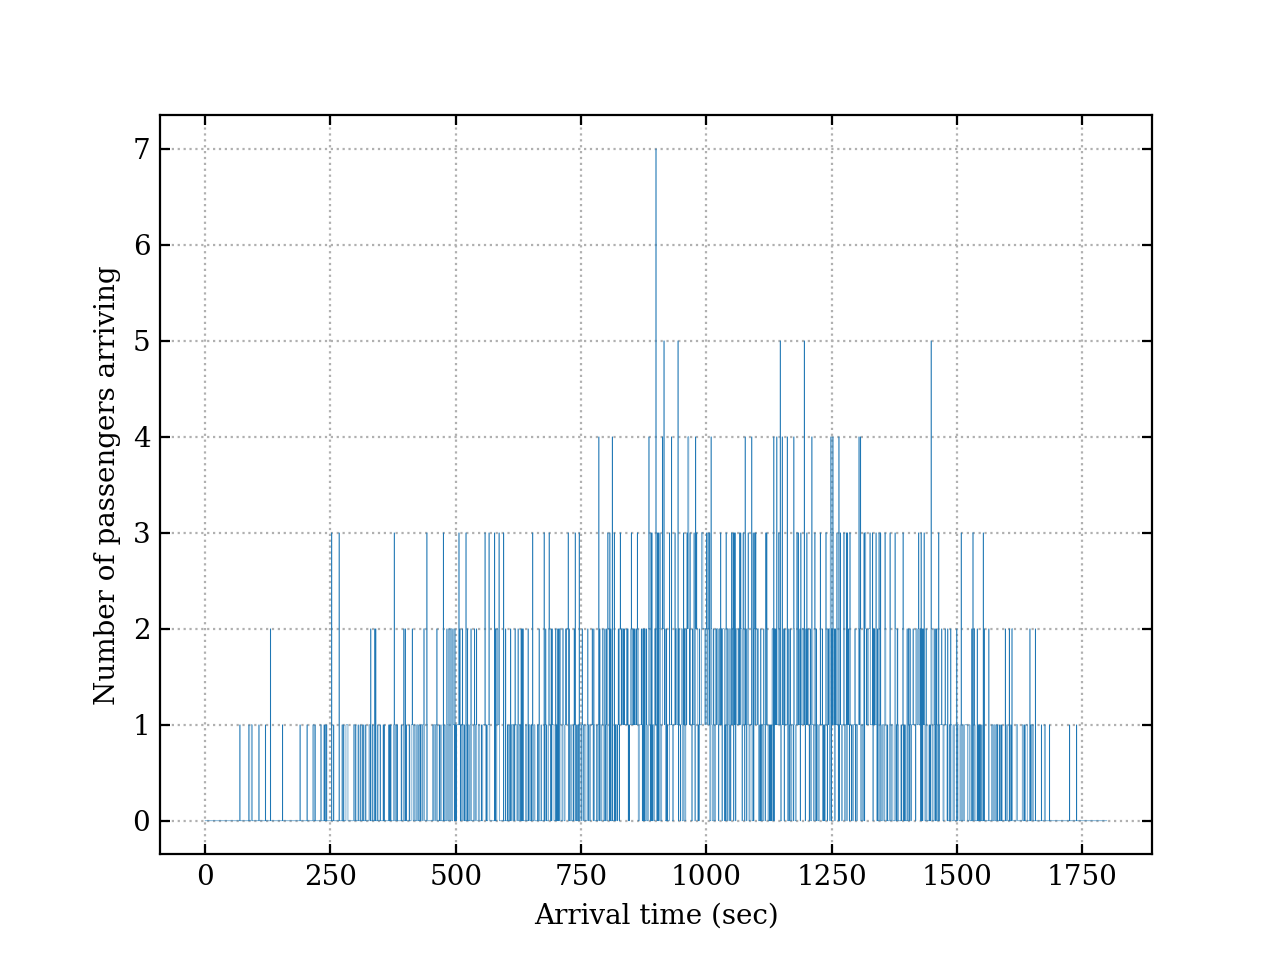

In [8]:
traffic_count = []

for l in ynew:
    traffic_count += np.random.poisson(lam=l, size=60).tolist()

newfigure()
plt.step(range(0, len(traffic_count)), traffic_count, linewidth=0.2)
plt.xlabel('Arrival time (sec)')
plt.ylabel('Number of passengers arriving')
plt.savefig('output/traffic_count.png')

Now, with the number of passengers set for each second in a 30 minute period, a destination floor must be assigned to each passenger. This should be allocated with equal probability of any destination floor required.

In [9]:
traffic = []
user_id = 0
for timestamp, num_users_per_sec in enumerate(traffic_count):
    for user in range(0,num_users_per_sec):
        
        dest_floor = np.random.randint(1,nfloors+1)
        
        user = {'id':user_id,
                'time.start':timestamp,
                'destination':dest_floor}
        traffic.append(user)
        user_id += 1

print("Average traffic flow: {}".format(len(traffic)/1800))

Average traffic flow: 0.7311111111111112


With the traffic now produced, we can check it to make sure that the floors requested a roughly distributed evenly over time.

<IPython.core.display.Javascript object>


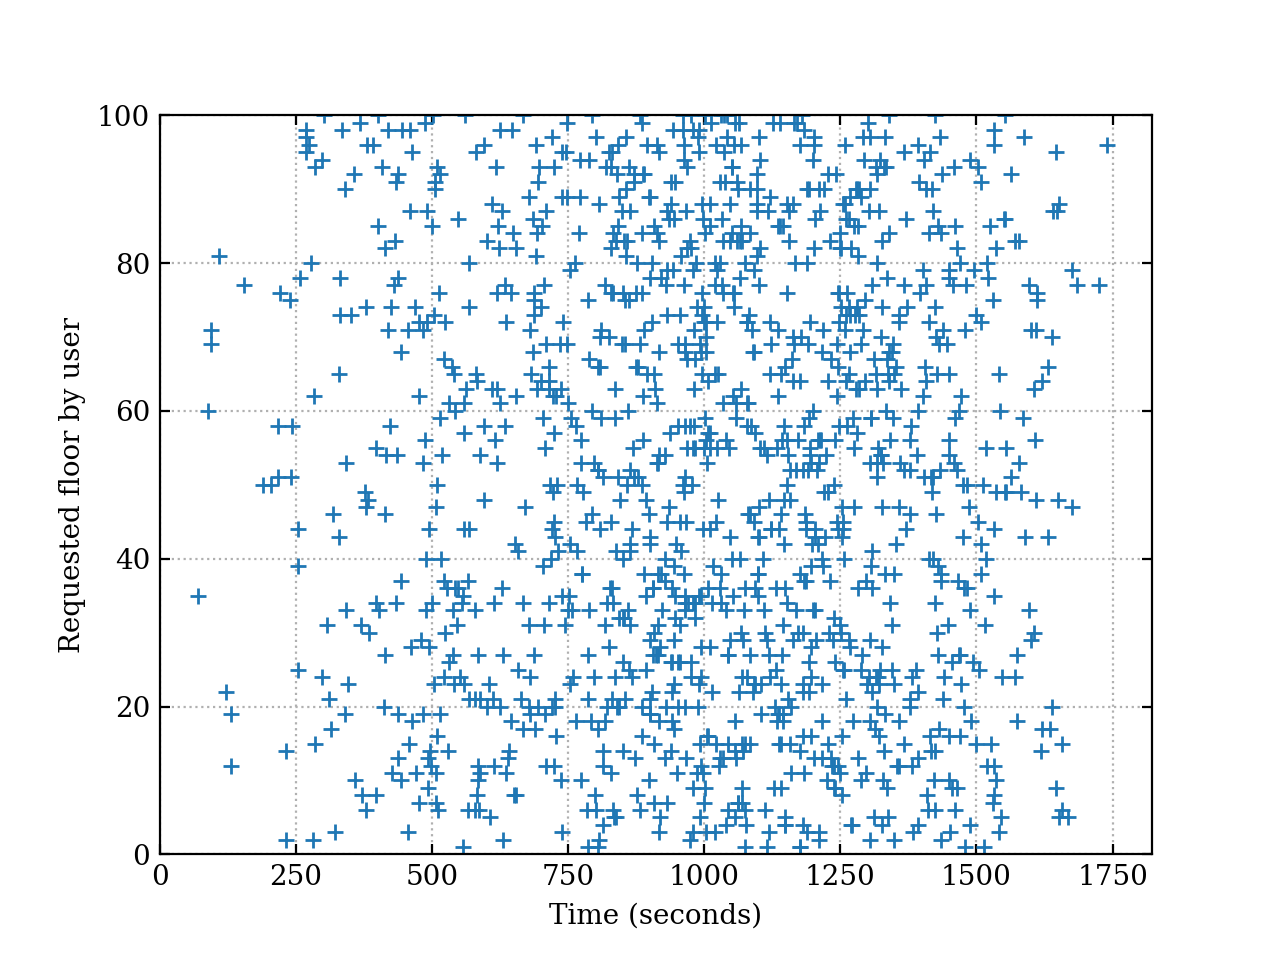

In [10]:
x = [u['time.start'] for u in traffic]
y = [u['destination'] for u in traffic]
newfigure()
plt.plot(x,y,'+')
plt.xlim(0)
plt.ylim(0,100)
plt.xlabel('Time (seconds)')
plt.ylabel('Requested floor by user')
plt.savefig('output/reqfloor_time.png')

# Lift System Simulation

In [11]:
# create a random list of passengers, one will arrive each second
floors = 100
total_passgr = 200
dest_floors = np.random.randint(1, floors+1, 200).tolist()
random_const_traffic = []
for i, dest_floor in enumerate(dest_floors):
    user = {'id':i,
            'time.start':i,
            'destination':dest_floor}
    random_const_traffic.append(user)

In [21]:
import subsystem2 # import relevant, abstracted code
from timeit import default_timer as timer
import matplotlib.animation as animation
import time






class Simulation:
    def __init__(self, iterations=60*60):
        self.iterations = iterations
        self.clock = 0
        self.floors = 100
        self.number_of_lifts = 8
        self.lift_capacity = 10
        self.departure_capacity_threshold = 0.8
        
        self.traffic = None
        self.assignment_func = None
        self.arrivals = []
        self.q = []
        self.lifts = []
        self.assignment_times = []
        for i in range(self.number_of_lifts):
            self.lifts.append(subsystem2.Lift(id=i, 
                                              capacity=self.lift_capacity, 
                                              capacity_threshold=self.departure_capacity_threshold))
        
        for lift in self.lifts:
            lift.set_print(False)

    def assign_greedy(self, passenger):
        # assign to the shortest lift queue
        lifts_by_queue_length = sorted(self.lifts, key=lambda lift: lift.get_queue_length())
        lifts_by_queue_length[0].queue_passenger(passenger, self.clock)

    def assign_nearest_lift(self, passenger):
        # assign to the queue of nearest lift unless the queue has reached capacity
        lifts_by_proximity = sorted(self.lifts, key=lambda lift: lift.get_arrival_time())
        for lift in lifts_by_proximity:
            if lift.get_queue_length() < lift.capacity:
                lift.queue_passenger(passenger, self.clock)
                return
        
        # all lift queues are at least as long as lift capacity
        self.assign_greedy(passenger)
        
    def assign_grouping(self, passenger):
        # order lifts by the average destination floor of each lift
        
        # establish lifts that will have no other passengers yet
        empty_lifts = [l for l in self.lifts if l.get_avg_floor() == 0]
                
        # order lifts by the distance between passenger destination floor 
        # and average destination floor of each lift
        lbnaf = sorted(self.lifts, key=lambda lift: abs(lift.get_avg_floor()-passenger['destination']))
        
        # best case, there is empty lift to fall back on
        if len(empty_lifts) > 0:
            if lbnaf[0].get_avg_floor() < 5:
                # if best lift is within a 5 floor threshold, then add the passenger
                lbnaf[0].queue_passenger(passenger, self.clock)
            else:
                # revert to just assigning them to their own lift
                empty_lifts[0].queue_passenger(passenger, self.clock)
        
        # no free lifts, so we put them in the most suitable one
        else:
            lbnaf[0].queue_passenger(passenger, self.clock)
    
    def set_traffic(self, t):
        self.total_traffic = len(t)
        self.traffic = t.copy()
        
    def set_assignment_func(self, name):
        self.func_name = name
        if name == 'greedy':
            self.assignment_func = self.assign_greedy
        elif name == 'nearest':
            self.assignment_func = self.assign_nearest_lift
        elif name == 'grouping':
            self.assignment_func = self.assign_grouping
        else:
            raise ValueError('The assignment func name \'{}\' is not recognised.'.format(name))
        
    def run(self):
        if self.traffic is None:
            raise TypeError('Traffic variable has not been set for the simulation.')
        if self.assignment_func is None:
            raise TypeError('Assignment function has not been set for the simulation.')
        while self.clock < self.iterations:
            self.step()
        
        print("-----------------------------------")
        print("SIMULATION COMPLETE")
        print("Assignment function:      {}".format(self.func_name))
        print("Duration of simulation:   {}".format(self.iterations))
        print("Total passengers arrived: {}".format(len(self.arrivals)))
        print("Total traffic:            {}".format(self.total_traffic))
        print("Percentage processed:     {:2.0f}%".format(len(self.arrivals)/self.total_traffic*100))
        print("Throughput (people/sec):  {:.4f}".format(len(self.arrivals)/self.iterations))
        print("-----------------------------------")
        
    
    def step(self):     
        # NEW ARRIVALS
        # move new arrivals from traffic into the queue
        while len(self.traffic) > 0:
            user = self.traffic[0]
            if user['time.start'] > self.clock:
                break # user has not arrived at building yet
            else:
                self.q.append(self.traffic.pop(0)) # user has arrived at the building


        # ASSIGNMENT ALGORITHM
        # Assign each person in the queue according to limits
        # 2 to 4 people per second can be allocated a lift
        for i in range(np.random.randint(2,5)):
            if len(self.q) > 0:
                waiting_passenger = self.q.pop(0) # remove from the queue
                start = timer()
                self.assignment_func(waiting_passenger) # assign passenger
                end = timer()
                self.assignment_times.append(end-start)
            else:
                break


        # UPDATE THE LIFT STATES
        # Check departure/arrival for all lifts
        for lift in self.lifts:
            if lift.is_available():
                lift.check_departure(self.clock)
            else:
                self.arrivals += lift.check_arrival(self.clock)


        # ITERATE THE CLOCK
        self.clock += 1

        # LIVE GRAPH
#         ax1.clear()
#         ax1.bar(range(5), [lift.get_total_passengers() for lift in lifts])
#         ax1.set_title('Passenger count')
#         ax1.set_ylim(0,10)
#         fig.canvas.draw()
#         time.sleep(0.01)
    


# fig = newfigure()
# ax1 = fig.add_subplot(111)

# plt.ion()
# fig.show()
# fig.canvas.draw()

n_iter = 60*60*3

sims = []
algs = ['greedy', 'nearest', 'grouping']

for i, alg in enumerate(algs):
    sim = Simulation(iterations=n_iter)
    sim.set_traffic(traffic)
    sim.set_assignment_func(alg)
    sim.run()
    sims.append(sim)

# pprint(sim1.arrivals)
# pprint(sim2.arrivals)

-----------------------------------
SIMULATION COMPLETE
Assignment function:      greedy
Duration of simulation:   10800
Total passengers arrived: 1296
Total traffic:            1316
Percentage processed:     98%
Throughput (people/sec):  0.1200
-----------------------------------
-----------------------------------
SIMULATION COMPLETE
Assignment function:      nearest
Duration of simulation:   10800
Total passengers arrived: 1288
Total traffic:            1316
Percentage processed:     98%
Throughput (people/sec):  0.1193
-----------------------------------
-----------------------------------
SIMULATION COMPLETE
Assignment function:      grouping
Duration of simulation:   10800
Total passengers arrived: 1288
Total traffic:            1316
Percentage processed:     98%
Throughput (people/sec):  0.1193
-----------------------------------


<IPython.core.display.Javascript object>


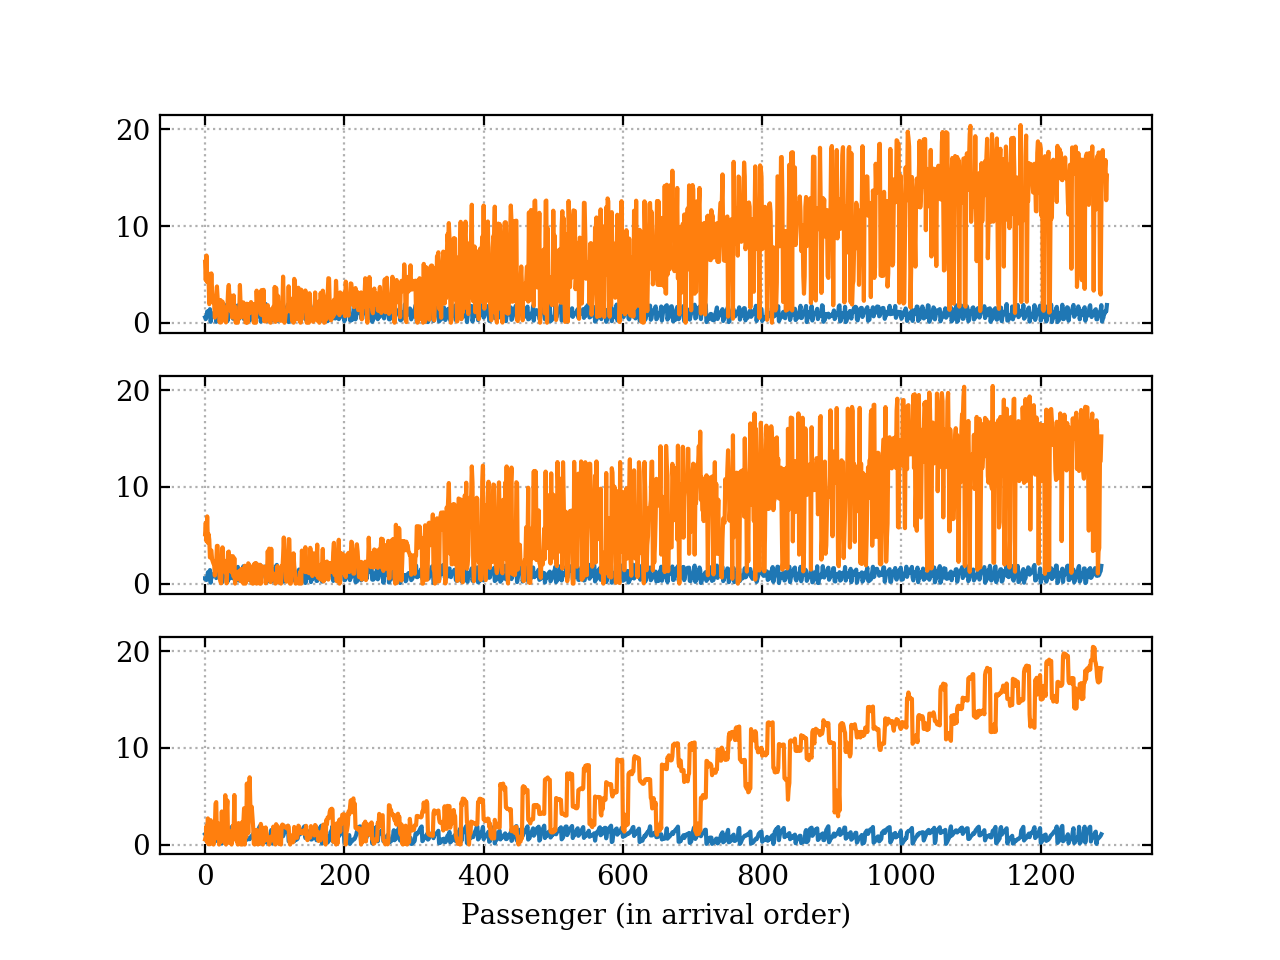

In [22]:


fig, axarr = plt.subplots(len(sims), sharex=True)
for i, sim in enumerate(sims):
    waittimes = [p['time.departure']-p['time.lobby'] for p in sim.arrivals]
    traveltimes = [p['time.travelling'] for p in sim.arrivals]
    
    # convert to minutes
    waittimes = list(map(lambda t: t/60, waittimes))
    traveltimes = list(map(lambda t: t/60, traveltimes))

    # traveltimes.sort()
    # waittimes.sort()
    
    
    x = range(len(traveltimes))
    
#     plt.plot(x, traveltimes, x, waittimes)
#     plt.legend(['Travelling', 'Waiting'])
#     plt.xlabel('Passenger (in order of arrival)')
#     plt.ylabel('Time')


    
    axarr[i].plot(x, traveltimes, x, waittimes)
    
    
#     axarr[i].set_yticks(np.arange(0,m,1), minor=True)
    
    axarr[i].tick_params(which='both', direction='in', grid_linestyle=":", top=True, right=True)
    axarr[i].grid(which='major', axis='both', linestyle=":")

axarr[-1].set_xlabel('Passenger (in arrival order)')
fig.savefig('output/poisson_comparison.png')

In [ ]:
# plot lift floor against time
for sim in sims:
    pass

In [14]:
# Example code that definetly works for animating data in plot

# import numpy as np
# import matplotlib.pyplot as plt

# m = 100
# n = 100
# matrix = np.random.normal(0,1,m*n).reshape(m,n)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.ion()

# fig.show()
# fig.canvas.draw()

# for i in range(0,100):
#     ax.clear()
#     ax.plot(matrix[i,:])
#     fig.canvas.draw()